In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
import random
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import seaborn as sns

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix

from keras import backend as K
import gc

In [ ]:
!git clone https://github.com/EdoardoGit/ML_Colab.git

Cloning into 'ML_Colab'...
remote: Enumerating objects: 24980, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 24980 (delta 0), reused 6 (delta 0), pack-reused 24974
Receiving objects: 100% (24980/24980), 895.68 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (25003/25003), done.


In [ ]:
CATEGORIE = ("Dogs/","Cats/")
DIR='/content/ML_Colab/CatsDogs/'
IMG_SIZE = 100

In [ ]:
EARLY_STOP_PATIENCE=5
OUTPUT_LOSS_PATH="output_loss_fold"
OUTPUT_VAL_PATH="output_val_fold"
OUTPUT_CONF_PATH="output_conf_fold"
OUTPUT_MEAN_LOSS_PATH="output_mean_loss"
OUTPUT_MEAN_ACC_PATH="output_mean_acc"
OUTPUT_MEAN_CONF_PATH="output_mean_conf"

In [ ]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

In [ ]:
bad_ids=[]
for n in bad_dog_ids:
  bad_ids.append([str(n)+".jpg",0])
for n in bad_cat_ids:
  bad_ids.append([str(n)+".jpg",1])

In [ ]:
#costruisco il dataset con IMG(gray),label
def create_training_data():
  training_data = []
  bad_data=[]
  for categories in CATEGORIE:
    path = os.path.join(DIR,categories)
    print(path)
    class_num = CATEGORIE.index(categories)
    for image in tqdm(os.listdir(path)):
      if([image,class_num] in bad_ids):
        try:
          img_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
          #print(image)
          #if img_array is None:
          #  print('Wrong path:', os.path.join(path,image))
          #else:
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

          bad_data.append([new_array,class_num])
        except Exception as e:
          #print("Immagine danneggiata")
          pass
      else:
        try:
          img_array = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
          #print(img_array.shape)
          #if img_array is None:
          #  print('Wrong path:', os.path.join(path,image))
          #else:
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))

          training_data.append([new_array,class_num])
        except Exception as e:
          #print(e)
          pass
  return training_data,bad_data

In [ ]:
data,bad_data=create_training_data()

/content/ML_Colab/CatsDogs/Dogs/


100%|██████████| 12500/12500 [00:14<00:00, 877.35it/s]


/content/ML_Colab/CatsDogs/Cats/


100%|██████████| 12500/12500 [00:13<00:00, 935.98it/s] 


In [ ]:
#mischio i dati
random.shuffle(data)

In [ ]:
def data_construct(data):
  input=[]
  output=[]

  for img,label in data:
    input.append(img)
    y=np.zeros(len(CATEGORIE))
    y[label]=1
    output.append(y)
  input=np.array(input).reshape(-1,IMG_SIZE,IMG_SIZE,1)
  return input,output

In [ ]:
X,y = data_construct(data)

In [ ]:
X_bad,y_bad = data_construct(bad_data)

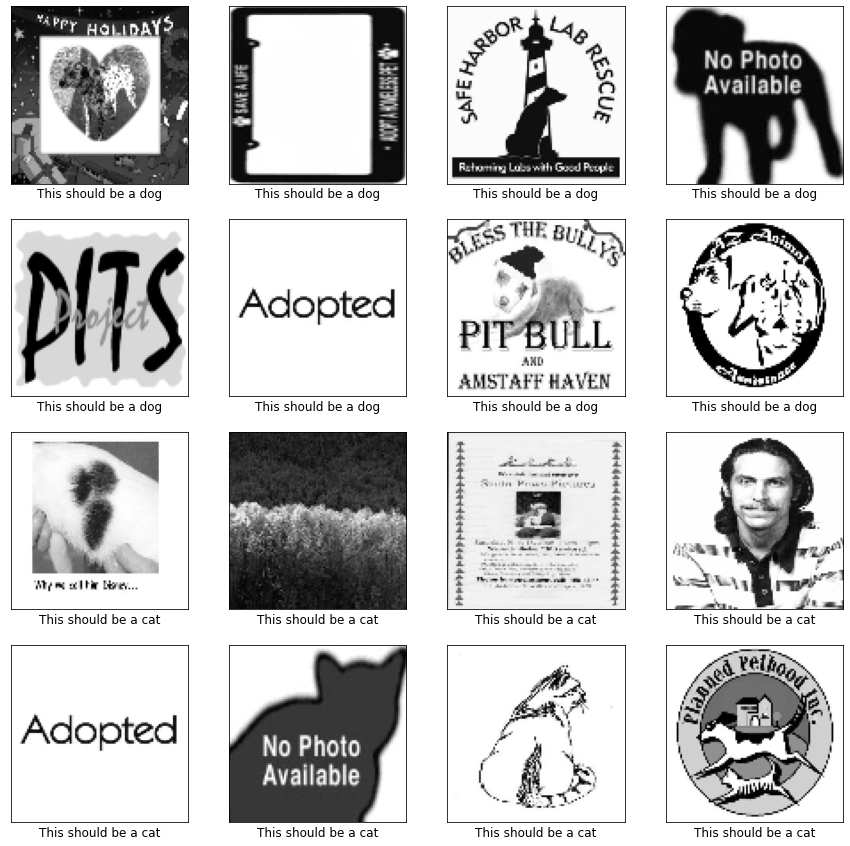

In [ ]:
#print dei campioni non validi
plt.figure(figsize=(15, 15))
grid_shape = (4, 4)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_bad[i][:,:,0],cmap='gray')
    plt.xlabel(f'This should be a {"dog" if y_bad[i][0] == 1 else "cat"}', size=12)
plt.savefig('grid_bad_data')
plt.show()

In [ ]:
#converto e normalizzo X
X=np.asarray(X)
y=np.asarray(y)
X = X/ 255

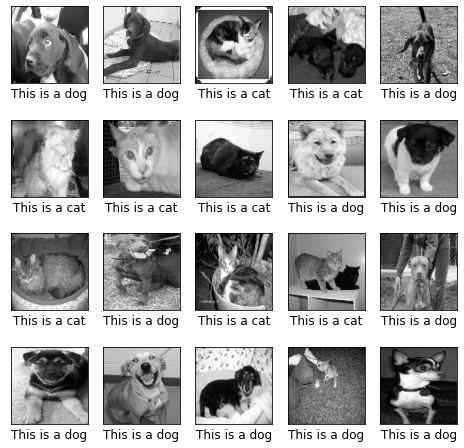

In [ ]:
#check dei primi 20 campioni
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'This is a {"dog" if y[i][0] == 1 else "cat"}', size=12)
plt.savefig('grid_example')
plt.show()

In [ ]:
#h->train history, path->dove salvare
def save_loss_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  #plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["custom_zero_loss"],label="0-1_loss")
  #plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  plt.plot(H.history["val_custom_zero_loss"],label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train Loss and 0-1 Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->train history, path->dove salvare
def save_val_plot(H,path):
  plt.style.use("ggplot")
  plt.figure()
  #plt.plot(H.history["loss"],label="train_loss")
  #plt.plot(H.history["val_loss"],label="val_loss")
  plt.plot(H.history["categorical_accuracy"],label="train_acc")
  plt.plot(H.history["val_categorical_accuracy"],label="val_acc")
  #plt.plot(H.history["val_custom_zero_loss"],label="val_loss")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix delle fold
def save_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la confusion matrix media
def save_mean_conf_plot(y_true,y_pred,path):
  #converto gli array da (p,1-p) a (0/1)
  ypred_s=[]
  for data_pred in y_pred:
    if data_pred[0]>0.5:
      ypred_s.append(1)
    else:
      ypred_s.append(0)
  
  ytrue_s=[]
  for y_t in y_true:
    ytrue_s.append(int(y_t[0]))

  plt.figure()
  cfm = confusion_matrix(ytrue_s, ypred_s)
  cfm=cfm/n_splits
  print(cfm)
  ax= plt.subplot()
  sns.heatmap(cfm, annot=True, ax = ax, fmt='g');
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels(['cats', 'dogs'])
  ax.yaxis.set_ticklabels(['cats', 'dogs'])
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la loss media
def save_mean_loss_plot(mloss,mozloss,meanvalozloss,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(mloss,label="train_loss")
  plt.plot(mozloss,label="train_0-1_loss")
  plt.plot(meanvalozloss,label="val_0-1_loss")
  plt.title("Loss")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Loss")
  plt.legend()
  plt.savefig(path)

In [ ]:
#h->data history, path->dove salvare
#definisco la funzione per visualizzare la accuracy media
def save_mean_acc_plot(macc,mvalacc,path):
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(macc,label="train_acc")
  plt.plot(mvalacc,label="val_acc")
  plt.title("Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Train and Test Accuracy")
  plt.legend()
  plt.savefig(path)

In [ ]:
m=tf.keras.metrics.CategoricalAccuracy()

In [ ]:
def custom_zero_loss(y_true, y_pred):
  m.reset_state()
  m.update_state(y_true,y_pred)
  return 1-m.result()

CLEAN STANDARD 2 CONV + 1 DENSE + DROPOUT + EARLY STOPPING

In [ ]:
#definisco l'early stopping per il training
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco l'architettura (STANDARD 2 CONV LAYERS)
def model_builder():
  model = Sequential()

  #input layer
  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))

  #hidden layer
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (64,(3,3), activation='relu'))
  model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Flatten ())
  model.add (Dropout (0.5))
  model.add (Dense(64, activation='relu'))
  model.add (Dropout (0.5))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=20
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
312/312 [==============================] - 20s 38ms/step - loss: 0.6216 - categorical_accuracy: 0.6506 - custom_zero_loss: 0.3494 - val_loss: 0.5230 - val_categorical_accuracy: 0.7381 - val_custom_zero_loss: 0.2619
Epoch 2/20
312/312 [==============================] - 10s 33ms/step - loss: 0.5066 - categorical_accuracy: 0.7566 - custom_zero_loss: 0.2433 - val_loss: 0.4819 - val_categorical_accuracy: 0.7673 - val_custom_zero_loss: 0.2327
Epoch 3/20
312/312 [==============================] - 11s 34ms/step - loss: 0.4494 - categorical_accuracy: 0.7941 - custom_zero_loss: 0.2058 - val_loss: 0.4700 - val_categorical_accuracy: 0.7669 - val_custom_zero_loss: 0.2330
Epoch 4/20
312/312 [==============================] - 10s 33ms/step - loss: 0.4180 - categorical_accuracy: 0.8089 - custom_zero_loss: 0.1911 - val_loss: 0.4599 - val_categorical_accuracy: 0.7862 - val_custom_zero_loss: 0.2139
Epoch 5/20
312/312 [==============================] - 11s 34ms/step - loss: 0.3760 -

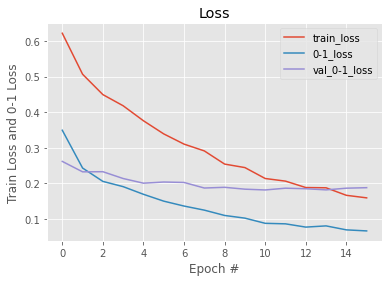

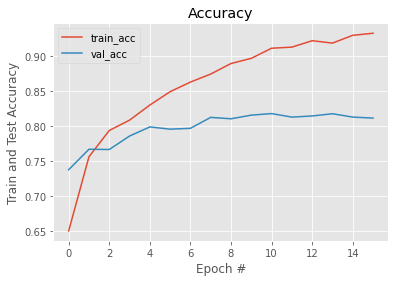

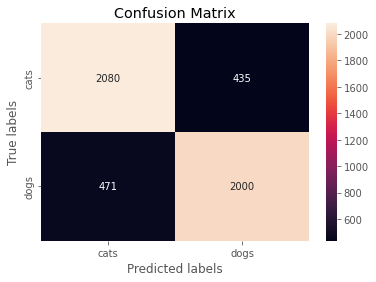

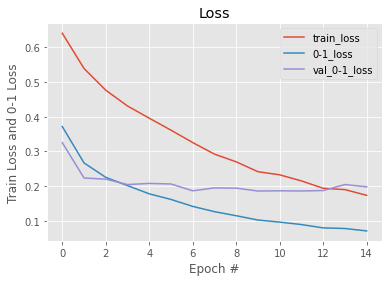

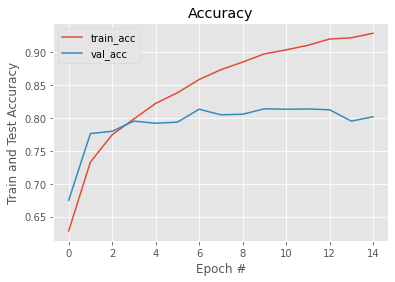

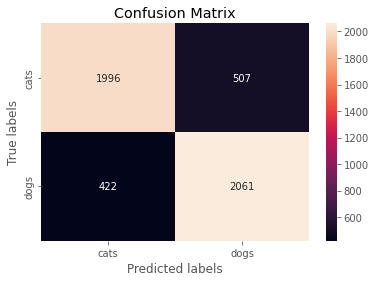

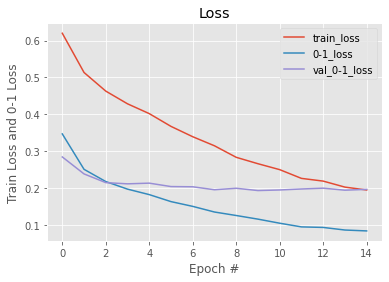

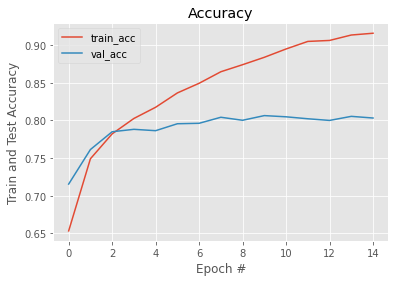

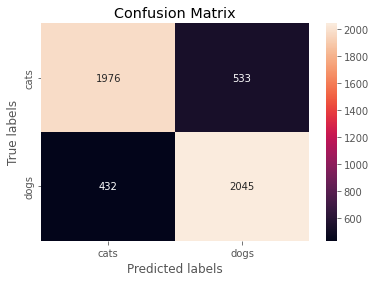

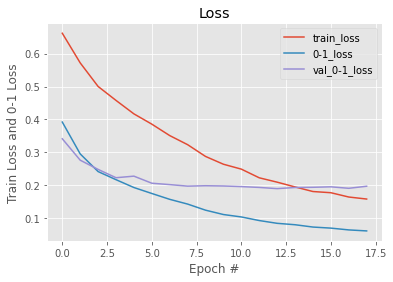

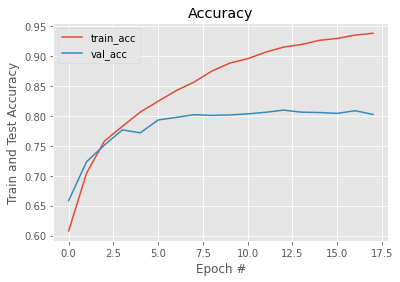

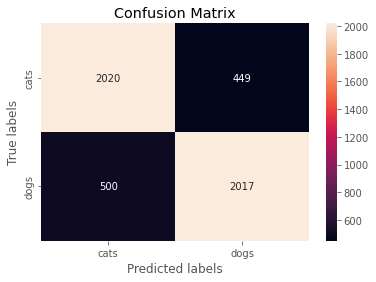

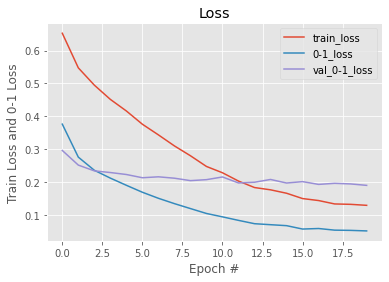

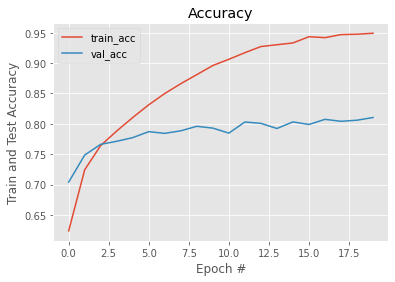

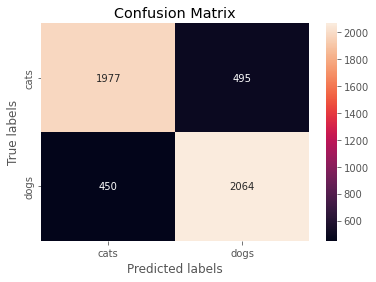

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.49954402446746826 - Accuracy: 0.818291187286377% - Zero-One N Loss: 906 - Zero-One Loss: 0.18170878459687123%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4504930078983307 - Accuracy: 0.8136783242225647% - Zero-One N Loss: 929 - Zero-One Loss: 0.18632170076213395%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5060164332389832 - Accuracy: 0.806458055973053% - Zero-One N Loss: 965 - Zero-One Loss: 0.19354191736863213%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5068159103393555 - Accuracy: 0.8096670508384705% - Zero-One N Loss: 949 - Zero-One Loss: 0.19033293221018854%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.609244167804718 - Accuracy: 0.8104693293571472% - Zero-One N Loss: 945 - Zero-One Loss

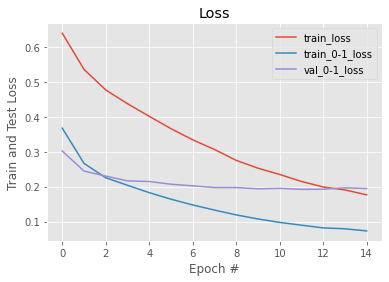

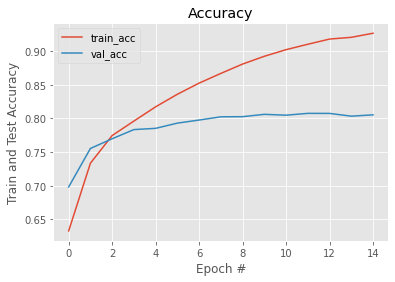

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2009.8  483.8]
 [ 455.  2037.4]]


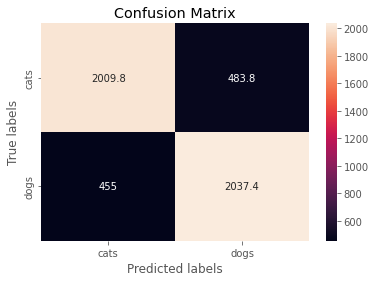

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

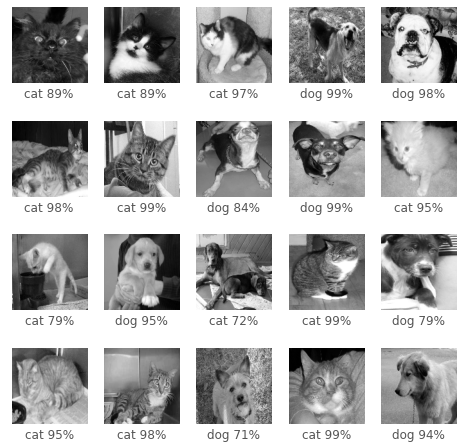

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

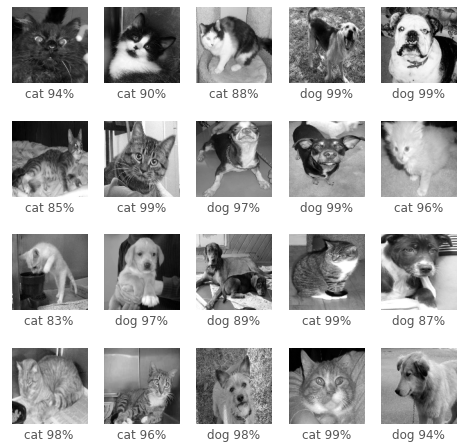

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

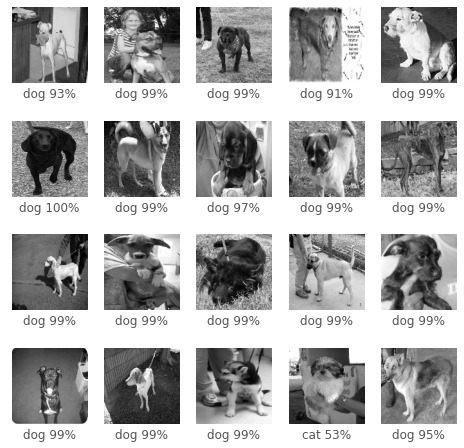

In [ ]:
data4=ypred[4]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data4[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

In [ ]:
model=model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dropout (Dropout)           (None, 50176)             0

HYPERPARAMETER TUTORIAL M CONV N DENSE

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.5 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYP_TUNING M CONV LAYER)
def model_builder(hp):
  model = Sequential()
  
  hp_filters=hp.Choice('num_of_filters',values=[32,64])
  hp_nConv=hp.Int('num_of_conv_layers',2,5)
  hp_dropout=hp.Choice('dropout_value',values=[0.4,0.5])
  hp_units=hp.Choice('num_of_neurons',values=[64,128])
  hp_nlayers=hp.Int('num_of_layers',1,3)

  for i in range(hp_nConv):
    if(i==0):
      #input layer
      model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu',input_shape = X.shape[1:]))
    else:
      #hidden layer
      model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu'))
    model.add (MaxPooling2D (pool_size=(2,2)))
  model.add (Conv2D (min(hp_filters*pow(2,hp_nConv),512),(3,3), activation='relu'))
  model.add (Flatten ())
  model.add (Dropout (hp_dropout))
  for i in range(hp_nlayers):
    model.add(Dense(units=hp_units*pow(2,hp_nlayers-1-i),activation='relu'))
    model.add (Dropout (hp_dropout))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=20,
    directory='turner4',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 5
num_of_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
num_of_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
dropout_value (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
num_of_neurons (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}


In [ ]:
#definisco i parametri del tuner
n_epochs=40
n_batch=64

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    batch_size = n_batch,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of starting filters: {}".format(
    bestHP.get("num_of_filters")))
print("[INFO] optimal number of conv layers: {}".format(
    bestHP.get("num_of_conv_layers")))
print("[INFO] optimal dropout value: {}".format(
    bestHP.get("dropout_value")))
print("[INFO] optimal number of last dense layer neurons: {}".format(
    bestHP.get("num_of_neurons")))
print("[INFO] optimal number of dense layers: {}".format(
    bestHP.get("num_of_layers")))
print("[INFO] optimal learning rate: {}".format(
    bestHP.get("learning_rate")))

Trial 20 Complete [00h 02m 15s]
val_categorical_accuracy: 0.9043321013450623

Best val_categorical_accuracy So Far: 0.9043321013450623
Total elapsed time: 00h 34m 19s
[INFO] optimal number of starting filters: 32
[INFO] optimal number of conv layers: 3
[INFO] optimal dropout value: 0.4
[INFO] optimal number of last dense layer neurons: 128
[INFO] optimal number of dense layers: 2


KeyError: ignored

In [ ]:
#definisco l'early stopping per il training
stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco la funzione di LR reduction
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

In [ ]:
#definisco training e crossvalidation
n_splits=5

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model=tuner.hypermodel.build(bestHP)

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test,learning_rate_reduction],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/40
312/312 [==============================] - 10s 25ms/step - loss: 0.6663 - categorical_accuracy: 0.5855 - custom_zero_loss: 0.4146 - val_loss: 0.5996 - val_categorical_accuracy: 0.6819 - val_custom_zero_loss: 0.3181 - lr: 0.0010
Epoch 2/40
312/312 [==============================] - 7s 22ms/step - loss: 0.5385 - categorical_accuracy: 0.7347 - custom_zero_loss: 0.2652 - val_loss: 0.4749 - val_categorical_accuracy: 0.7770 - val_custom_zero_loss: 0.2230 - lr: 0.0010
Epoch 3/40
312/312 [==============================] - 7s 23ms/step - loss: 0.4438 - categorical_accuracy: 0.7981 - custom_zero_loss: 0.2020 - val_loss: 0.4286 - val_categorical_accuracy: 0.8051 - val_custom_zero_loss: 0.1950 - lr: 0.0010
Epoch 4/40
312/312 [==============================] - 7s 22ms/step - loss: 0.3847 - categorical_accuracy: 0.8299 - custom_zero_loss: 0.1701 - val_loss: 0.3857 - val_categorical_accuracy: 0.8295 - val_custom_zero_loss: 0.1704 - lr: 0.0010
Epoch 5/40
312/312 [===============

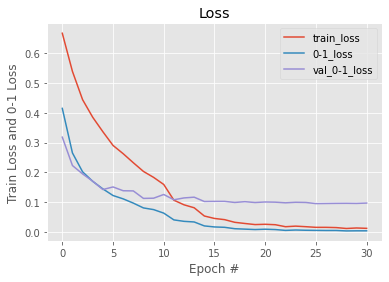

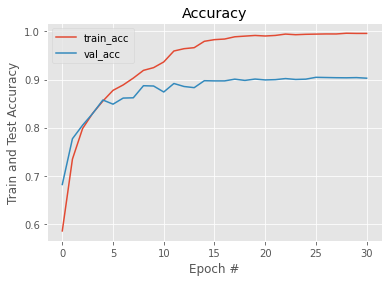

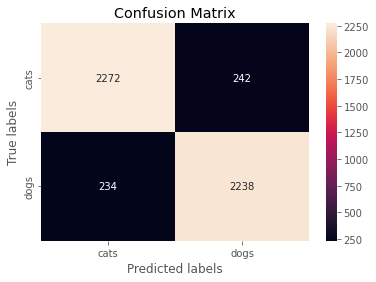

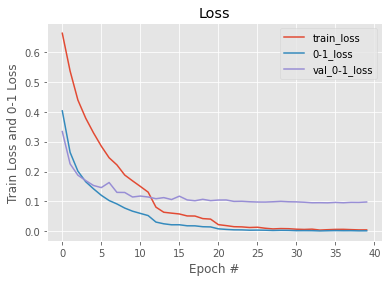

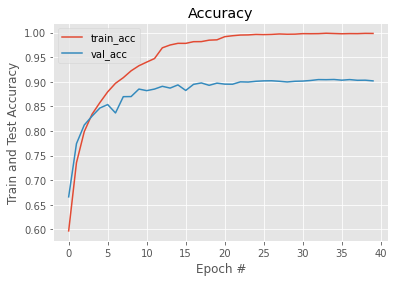

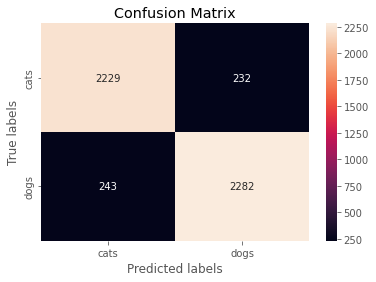

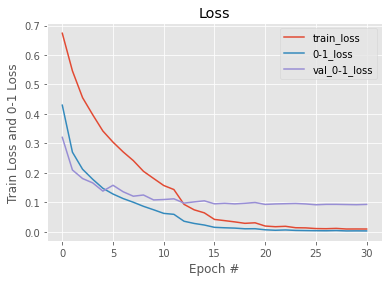

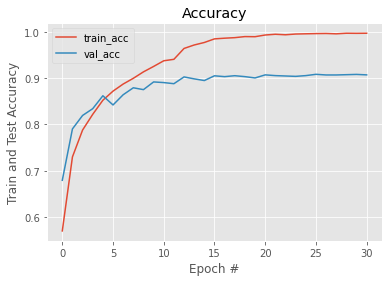

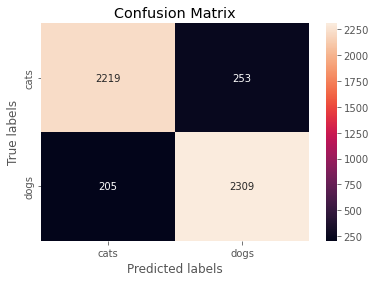

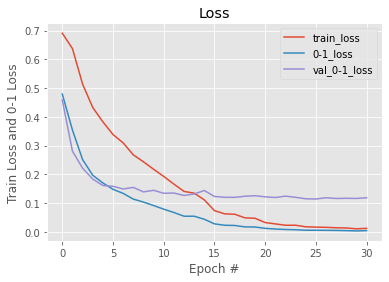

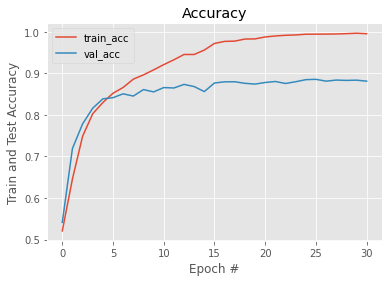

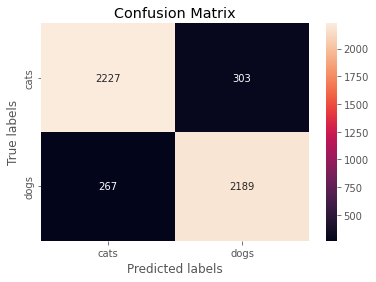

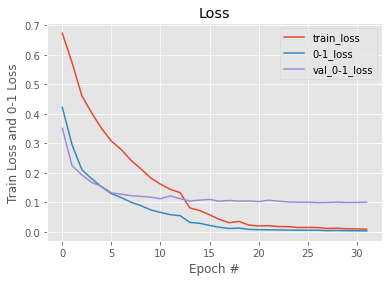

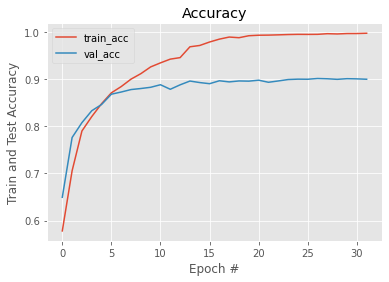

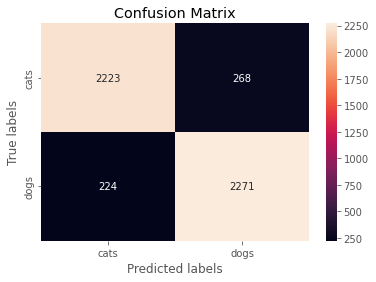

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5499472618103027 - Accuracy: 0.9045326709747314 - Zero-One N Loss: 476 - Zero-One Loss: 0.09546730846369833
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6475592255592346 - Accuracy: 0.9047332406044006 - Zero-One N Loss: 475 - Zero-One Loss: 0.09526674689129566
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5026096105575562 - Accuracy: 0.9081428050994873 - Zero-One N Loss: 458 - Zero-One Loss: 0.09185720016044929
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6159674525260925 - Accuracy: 0.8856799006462097 - Zero-One N Loss: 570 - Zero-One Loss: 0.11432009626955475
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5241544246673584 - Accuracy: 0.9013237357139587 - Zero-One N Loss: 492 - Zero-One Loss: 0.098

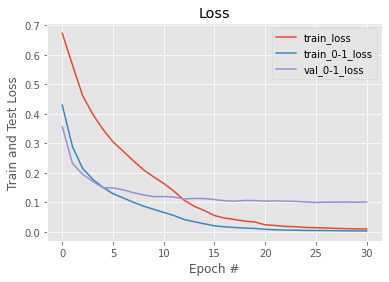

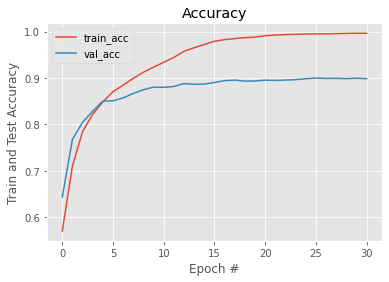

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(40,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(40,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(40,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(40,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(40,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2234.   259.6]
 [ 234.6 2257.8]]


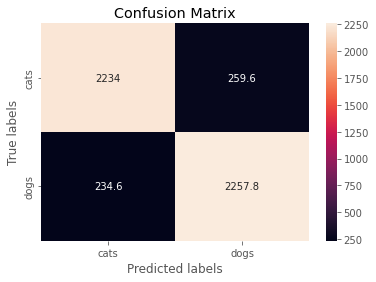

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

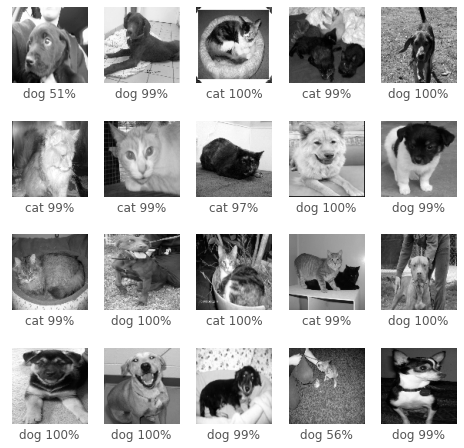

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

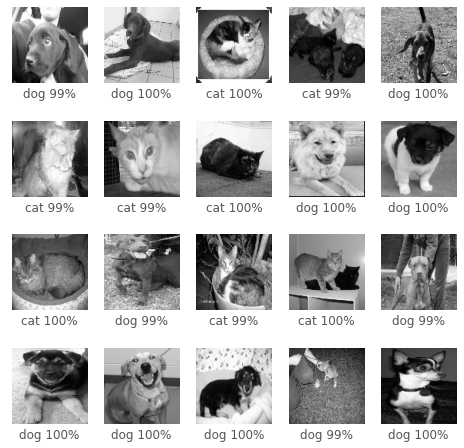

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

TEST WITHOUT NORMALIZATION

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco l'architettura (TEST 4 CONV NO BATCH LAYER)
def model_builder():
  model = Sequential()

  #input layer
  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))
  #model.add(BatchNormalization())

  #hidden layer
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64,(3,3),activation='relu'))
  #model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(3,3),activation='relu'))
  #model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(256,(3,3),activation='relu'))
  #model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add (Flatten ())
  model.add (Dense(512, activation='relu'))
  #model.add(BatchNormalization())
  model.add (Dropout (0.25))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=20
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/20
312/312 [==============================] - 17s 21ms/step - loss: 0.6750 - categorical_accuracy: 0.5641 - custom_zero_loss: 0.4359 - val_loss: 0.6319 - val_categorical_accuracy: 0.6394 - val_custom_zero_loss: 0.3606
Epoch 2/20
312/312 [==============================] - 5s 18ms/step - loss: 0.5946 - categorical_accuracy: 0.6840 - custom_zero_loss: 0.3158 - val_loss: 0.5525 - val_categorical_accuracy: 0.7170 - val_custom_zero_loss: 0.2829
Epoch 3/20
312/312 [==============================] - 6s 18ms/step - loss: 0.5253 - categorical_accuracy: 0.7410 - custom_zero_loss: 0.2589 - val_loss: 0.4716 - val_categorical_accuracy: 0.7806 - val_custom_zero_loss: 0.2194
Epoch 4/20
312/312 [==============================] - 6s 18ms/step - loss: 0.4685 - categorical_accuracy: 0.7771 - custom_zero_loss: 0.2229 - val_loss: 0.4083 - val_categorical_accuracy: 0.8153 - val_custom_zero_loss: 0.1846
Epoch 5/20
312/312 [==============================] - 6s 18ms/step - loss: 0.4214 - cat

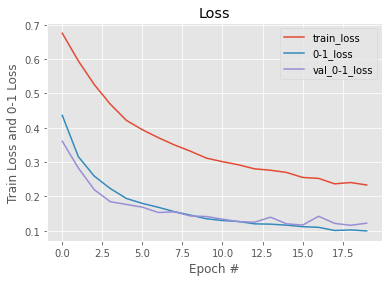

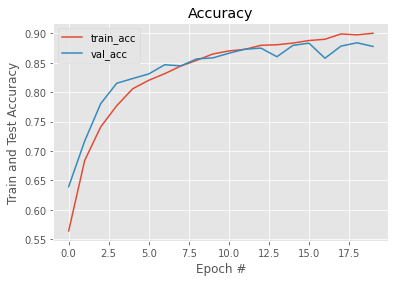

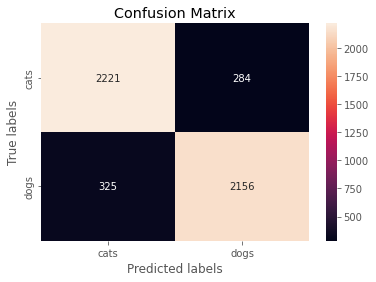

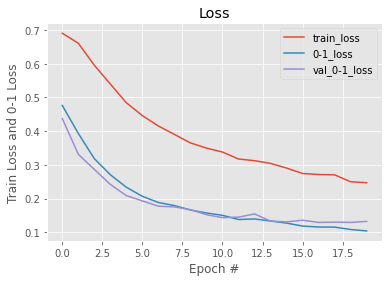

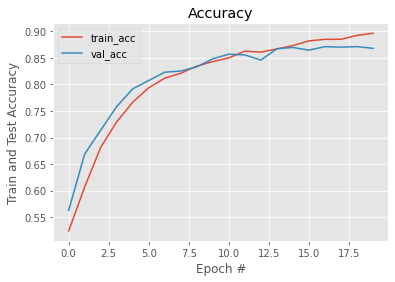

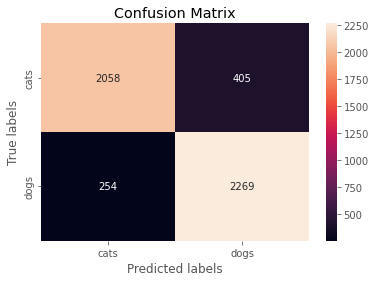

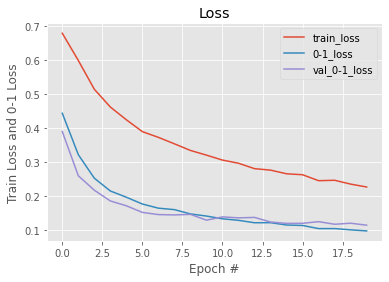

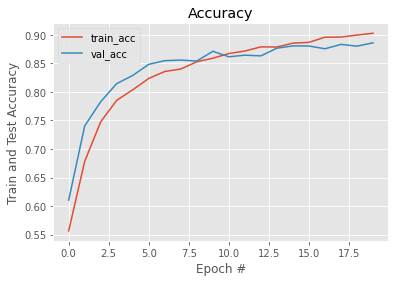

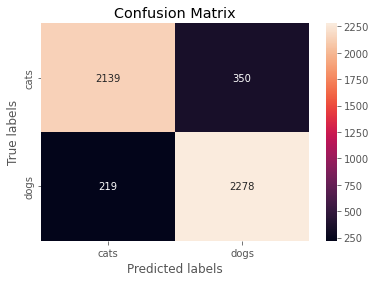

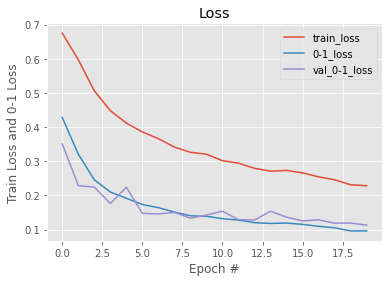

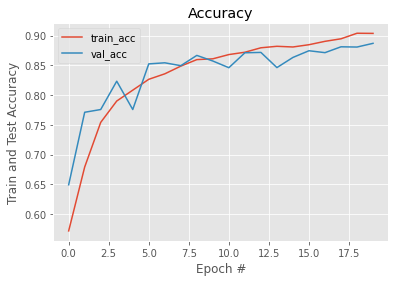

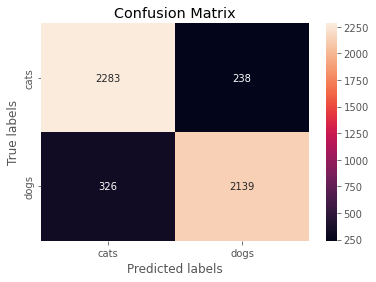

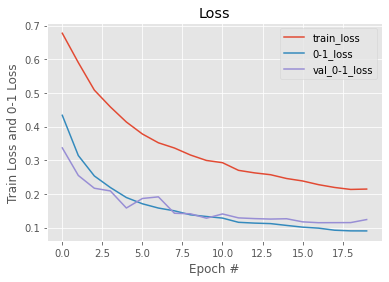

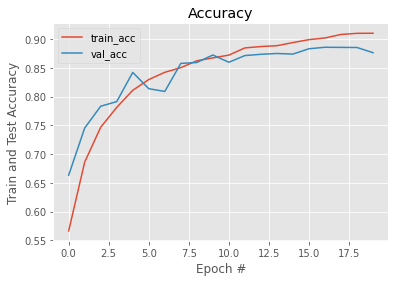

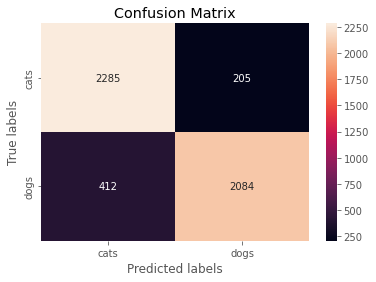

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.27923640608787537 - Accuracy: 0.8778579831123352% - Zero-One N Loss: 609 - Zero-One Loss: 0.12214199759326116%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.29438820481300354 - Accuracy: 0.8678299188613892% - Zero-One N Loss: 659 - Zero-One Loss: 0.1321700762133975%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.27778783440589905 - Accuracy: 0.8858804702758789% - Zero-One N Loss: 569 - Zero-One Loss: 0.11411953469715208%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.27160465717315674 - Accuracy: 0.8868832588195801% - Zero-One N Loss: 564 - Zero-One Loss: 0.1131167268351384%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.28670018911361694 - Accuracy: 0.8762534856796265% - Zero-One N Loss: 617 - Zero-One

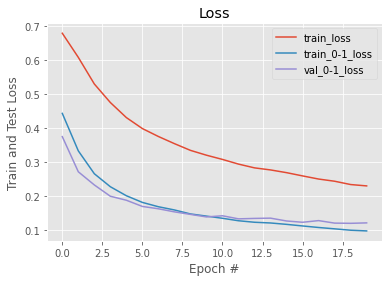

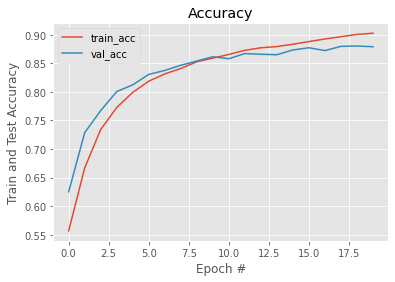

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2197.2  296.4]
 [ 307.2 2185.2]]


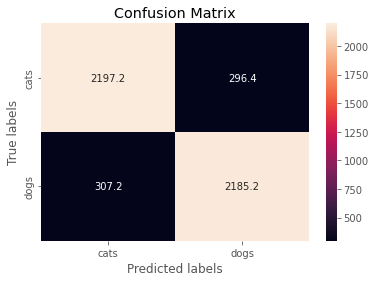

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

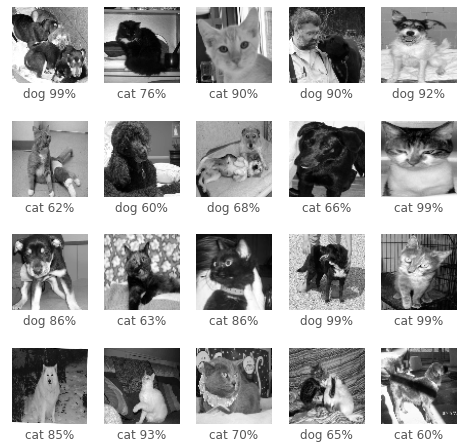

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

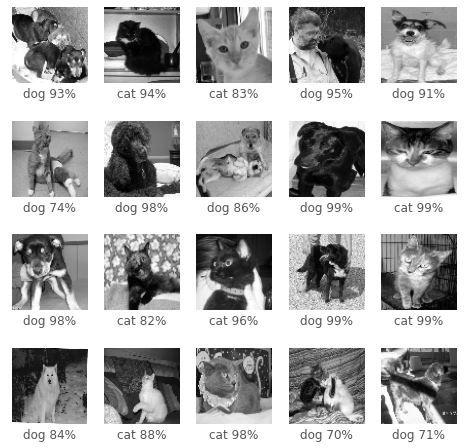

In [ ]:
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

In [ ]:
model=model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 64)        0

TEST WITH NORMALIZATION & REDUCELR

In [ ]:
#definisco l'early stopping per il training
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco la funzione di LR reduction
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

In [ ]:
#definisco l'architettura (TEST 4 CONV+BATCH LAYER)
def model_builder():
  model = Sequential()

  #input layer
  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))
  
  #hidden layer
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(256,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add (Flatten ())
  model.add (Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add (Dropout (0.25))

  #output layer
  model.add(Dense(2, activation="softmax"))
  
  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=40
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model = model_builder()

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early,learning_rate_reduction],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/40
312/312 [==============================] - 9s 25ms/step - loss: 0.7595 - categorical_accuracy: 0.6196 - custom_zero_loss: 0.3805 - val_loss: 1.6426 - val_categorical_accuracy: 0.5024 - val_custom_zero_loss: 0.4976 - lr: 0.0010
Epoch 2/40
312/312 [==============================] - 7s 21ms/step - loss: 0.5380 - categorical_accuracy: 0.7343 - custom_zero_loss: 0.2657 - val_loss: 0.6209 - val_categorical_accuracy: 0.6847 - val_custom_zero_loss: 0.3152 - lr: 0.0010
Epoch 3/40
312/312 [==============================] - 7s 22ms/step - loss: 0.4690 - categorical_accuracy: 0.7778 - custom_zero_loss: 0.2222 - val_loss: 0.4076 - val_categorical_accuracy: 0.8093 - val_custom_zero_loss: 0.1907 - lr: 0.0010
Epoch 4/40
312/312 [==============================] - 7s 22ms/step - loss: 0.4194 - categorical_accuracy: 0.8064 - custom_zero_loss: 0.1935 - val_loss: 0.5281 - val_categorical_accuracy: 0.7563 - val_custom_zero_loss: 0.2437 - lr: 0.0010
Epoch 5/40
312/312 [================

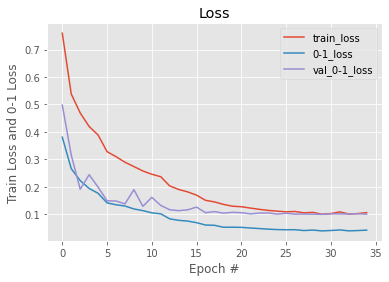

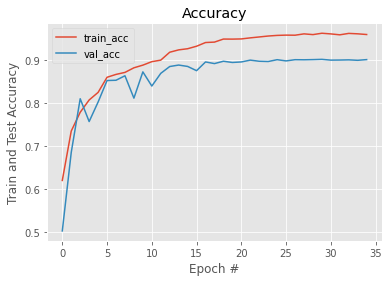

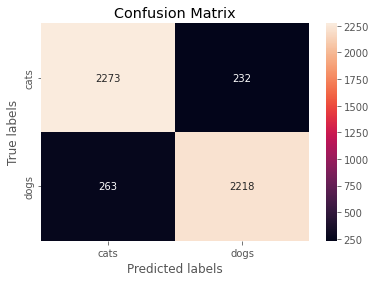

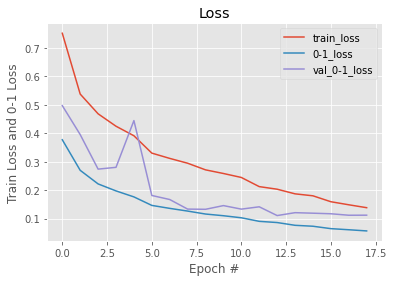

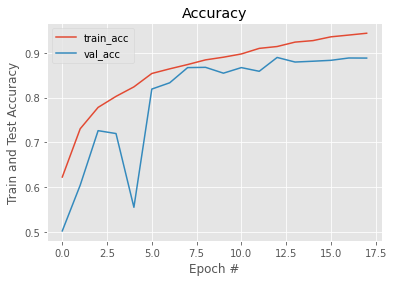

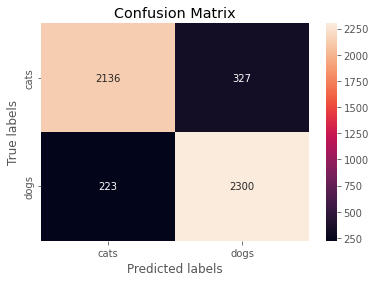

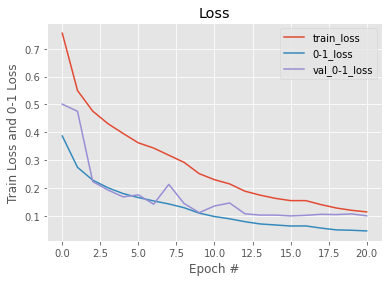

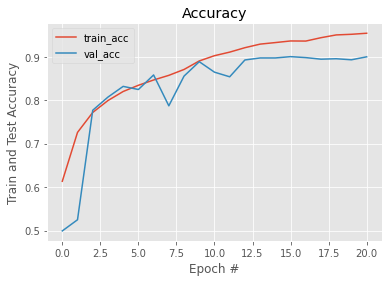

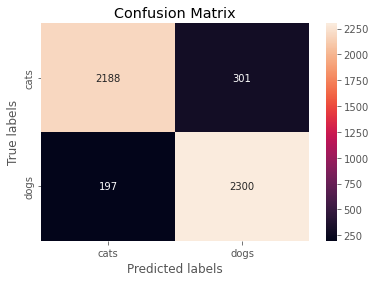

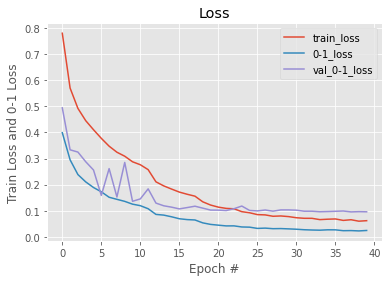

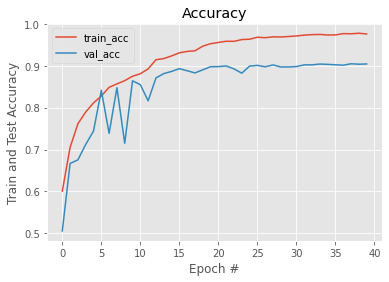

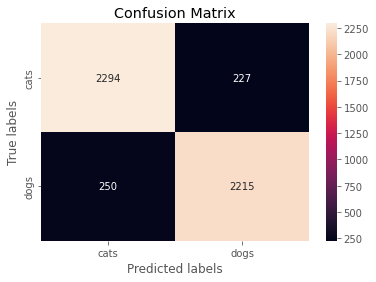

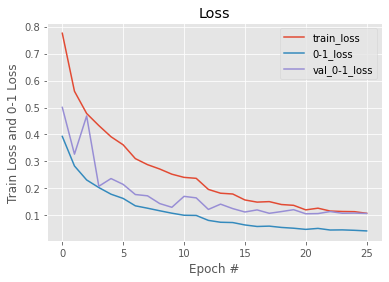

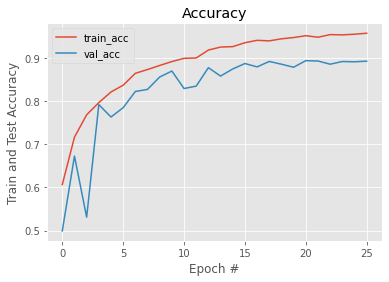

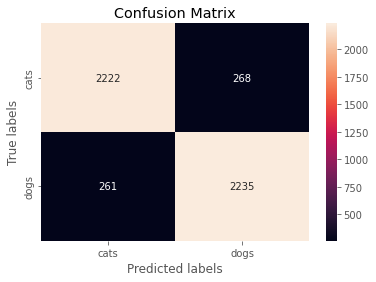

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]}% - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)}% (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)}% (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.28655973076820374 - Accuracy: 0.9007220268249512% - Zero-One N Loss: 495 - Zero-One Loss: 0.09927797833935015%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.27523183822631836 - Accuracy: 0.8896911144256592% - Zero-One N Loss: 550 - Zero-One Loss: 0.11030886482150015%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.26244986057281494 - Accuracy: 0.9001203179359436% - Zero-One N Loss: 498 - Zero-One Loss: 0.09987966305655838%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.29816678166389465 - Accuracy: 0.9043321013450623% - Zero-One N Loss: 477 - Zero-One Loss: 0.09566787003610111%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3033877909183502 - Accuracy: 0.8939029574394226% - Zero-One N Loss: 529 - Zero-On

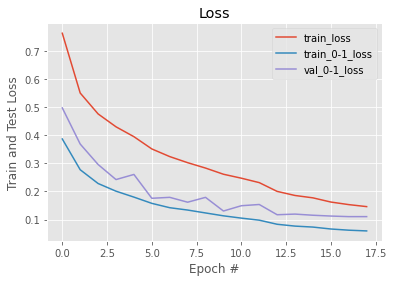

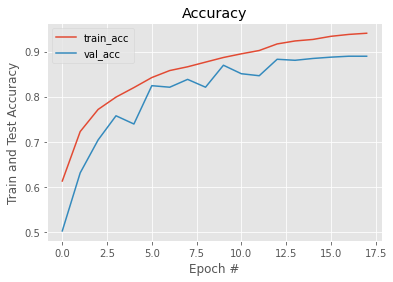

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2222.6  271. ]
 [ 238.8 2253.6]]


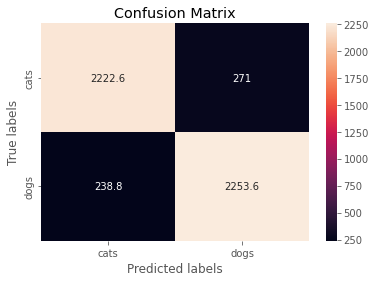

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

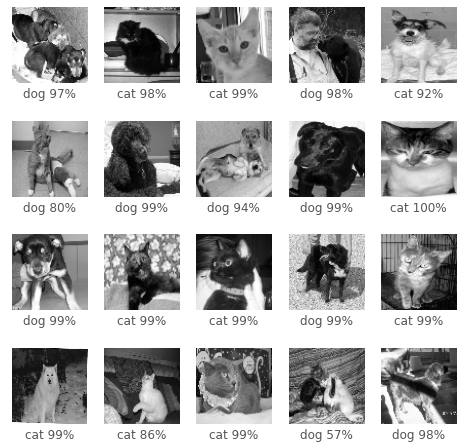

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

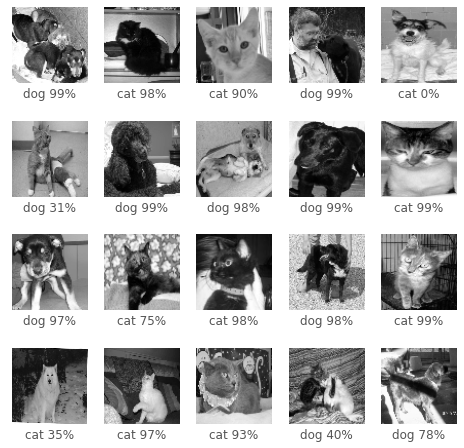

In [ ]:
#[0 1]-> cat,[1 0]->dog
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

In [ ]:
model=model_builder()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 34, 34, 64)       2

HYPERTUNING CONV+MP+BN+DROPOUT

In [ ]:
#definisco l'early stopping per il tuning
from tensorflow.keras.callbacks import EarlyStopping

stop_early=EarlyStopping(
    monitor="val_loss",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.7 MB/s eta 0:00:00


In [ ]:
#definisco l'architettura (HYPER CONV+BATCH)
def model_builder(hp):
  model = Sequential()
  
  hp_filters=hp.Choice('num_of_filters',values=[32,64])
  hp_dropout=hp.Choice('dropout_value',values=[0.2,0.3,0.4,0.5])
  hp_nlayers=hp.Int('num_of_layers',1,3)

  for i in range(hp.Int('num_of_conv_layers',2,5)):
    if(i==0):
      #input layer
      model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu',input_shape = X.shape[1:]))
    else:
      #hidden layer
      model.add (Conv2D (min(hp_filters*pow(2,i),512),(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(hp_dropout))
  model.add (Flatten ())
  for i in range(hp_nlayers):
    model.add(Dense(units=512/pow(2,i),activation='relu'))
    model.add(BatchNormalization())
    model.add (Dropout (hp_dropout))

  #output layer
  model.add(Dense(2, activation="softmax"))

  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
#costruisco il tuner
from keras_tuner import BayesianOptimization

tuner=BayesianOptimization(
    model_builder,
    objective='val_categorical_accuracy',
    max_trials=20,
    directory='turner5',
    project_name='ML')

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_of_filters (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
dropout_value (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4, 0.5], 'ordered': True}
num_of_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
num_of_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}


In [ ]:
#definisco i parametri del tuner
n_epochs=40
n_batch=64

tuner.search(
    x=X,
    y=y,
    validation_split=0.2,
    batch_size = n_batch,
    callbacks=[stop_early],
    epochs=n_epochs
)

bestHP=tuner.get_best_hyperparameters(num_trials=1)[0]
print("[INFO] optimal number of starting filters: {}".format(
    bestHP.get("num_of_filters")))
print("[INFO] optimal number of conv layers: {}".format(
    bestHP.get("num_of_conv_layers")))
print("[INFO] optimal dropout value: {}".format(
    bestHP.get("dropout_value")))
print("[INFO] optimal number of dense layers: {}".format(
    bestHP.get("num_of_layers")))

Trial 20 Complete [00h 05m 49s]
val_categorical_accuracy: 0.9025270938873291

Best val_categorical_accuracy So Far: 0.92158043384552
Total elapsed time: 01h 42m 33s
[INFO] optimal number of starting filters: 32
[INFO] optimal number of conv layers: 5
[INFO] optimal dropout value: 0.4
[INFO] optimal number of dense layers: 1


In [ ]:
#definisco l'early stopping per il training
stop_early_test=EarlyStopping(
    monitor="val_categorical_accuracy",
    patience=EARLY_STOP_PATIENCE,
    restore_best_weights=True
)

In [ ]:
#definisco la funzione di LR reduction
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_categorical_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

In [ ]:
#definisco training e crossvalidation
n_splits=5
n_epochs=50
n_batch=64

def train_and_crossvalidate(X_data,y_data,n_folds=n_splits,batch_size=n_batch):
  scores=[]
  check_pred=[]
  histories=[]
  y_mean_conf=[]

  #cross validation
  kf=KFold(n_folds)

  #splits
  FoldsSetN=0
  for train_index,test_index in kf.split(X_data):
    print('Fold Set #{0}'.format(FoldsSetN))
    X_train, y_train, X_test, y_test = X_data[train_index],y_data[train_index],X_data[test_index],y_data[test_index]

    #model
    model=tuner.hypermodel.build(bestHP)

    #fit
    history = model.fit(X_train,y_train,epochs=n_epochs,batch_size = n_batch,callbacks=[stop_early_test,learning_rate_reduction],validation_data=(X_test,y_test))
    histories.append(history)
    save_loss_plot(history,OUTPUT_LOSS_PATH+'#{0}'.format(FoldsSetN))
    save_val_plot(history,OUTPUT_VAL_PATH+'#{0}'.format(FoldsSetN))
    y_conf=model.predict(X_test)
    y_mean_conf.append(y_conf)
    save_conf_plot(y_test,y_conf,OUTPUT_CONF_PATH+'#{0}'.format(FoldsSetN))
    fold_eval=model.evaluate(X_test,y_test)
    print(f'Model Evaluation for fold {FoldsSetN}: Loss {fold_eval[0]} ---- Acc {fold_eval[1]}')

    #zero-one loss
    ypred_test = model.predict (X_test)
    n_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=False)
    p_zol=zero_one_loss(np.argmax(ypred_test, axis=1),np.argmax(y_test, axis=1),normalize=True)
    print(f'Zero-One Loss for fold {FoldsSetN}: {n_zol} n ---- {p_zol} %')

    scores.append({'val_loss':fold_eval[0], 
                   'val_acc':fold_eval[1],
                   'zero_one_n':n_zol,
                   'zero_one_p':p_zol})
    
    #memorizzo i primi 20
    y_check=model.predict (X_data[0:20])
    check_pred.append(y_check)

    #scores check
    #check=model.evaluate(X_test,y_test)
    #print(f'Score for fold {FoldsSetN}: {model.metrics_names[0]} of {check[0]}; {model.metrics_names[1]} of {check[1]*100}%')

    #clear model
    del model
    K.clear_session()
    gc.collect()

    FoldsSetN+=1
  return scores,check_pred,histories,y_mean_conf

Fold Set #0
Epoch 1/50
312/312 [==============================] - 14s 41ms/step - loss: 0.8573 - categorical_accuracy: 0.5713 - custom_zero_loss: 0.4286 - val_loss: 0.9293 - val_categorical_accuracy: 0.5114 - val_custom_zero_loss: 0.4885 - lr: 0.0010
Epoch 2/50
312/312 [==============================] - 12s 40ms/step - loss: 0.6220 - categorical_accuracy: 0.6656 - custom_zero_loss: 0.3342 - val_loss: 0.8117 - val_categorical_accuracy: 0.5716 - val_custom_zero_loss: 0.4285 - lr: 0.0010
Epoch 3/50
312/312 [==============================] - 12s 39ms/step - loss: 0.5483 - categorical_accuracy: 0.7229 - custom_zero_loss: 0.2770 - val_loss: 0.5479 - val_categorical_accuracy: 0.7092 - val_custom_zero_loss: 0.2907 - lr: 0.0010
Epoch 4/50
312/312 [==============================] - 12s 39ms/step - loss: 0.4984 - categorical_accuracy: 0.7581 - custom_zero_loss: 0.2420 - val_loss: 1.0378 - val_categorical_accuracy: 0.5614 - val_custom_zero_loss: 0.4386 - lr: 0.0010
Epoch 5/50
311/312 [============

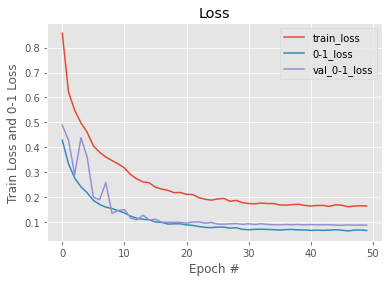

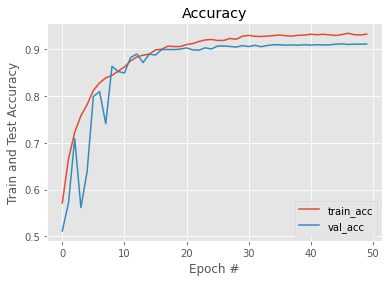

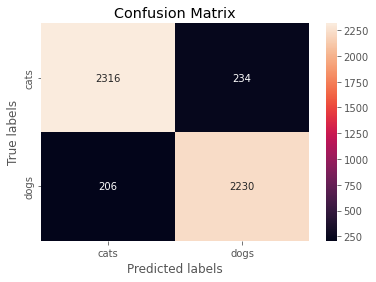

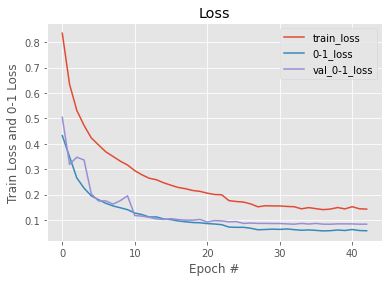

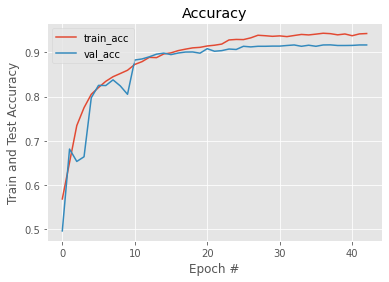

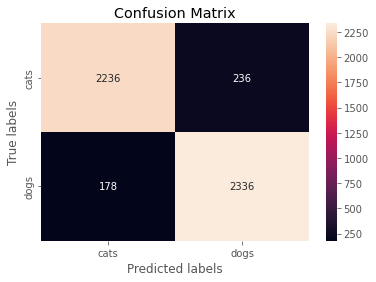

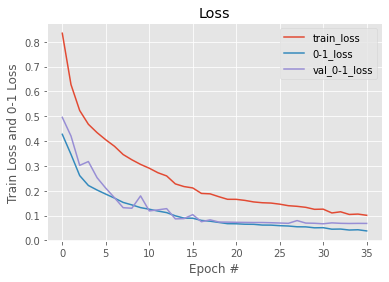

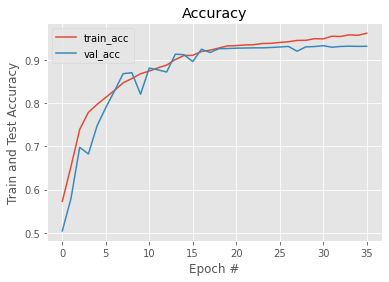

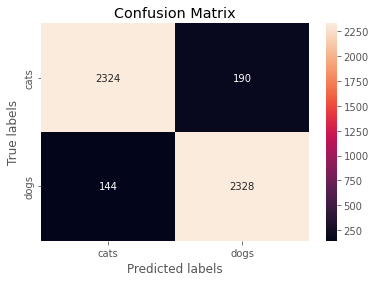

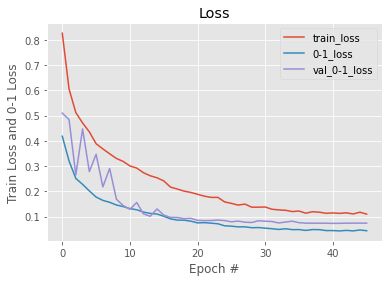

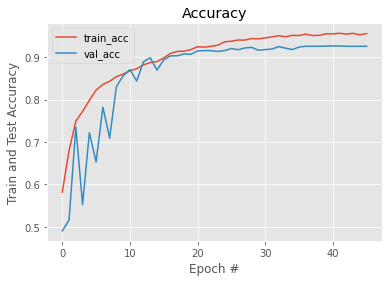

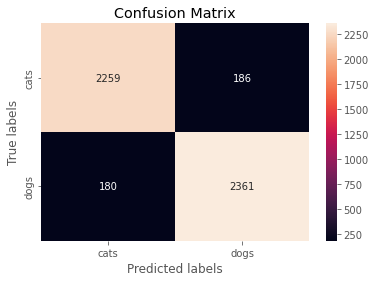

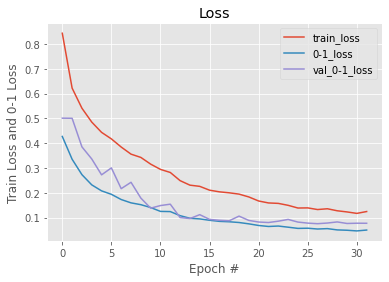

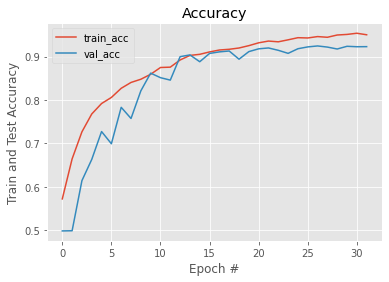

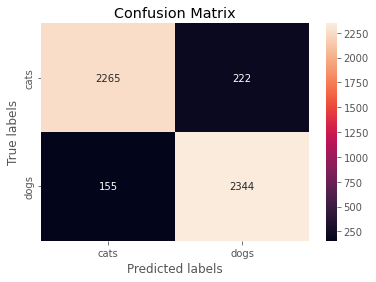

In [ ]:
scores,ypred,histories,y_mean_conf=train_and_crossvalidate(X,y)

In [ ]:
#Print degli scores
val_loss=[]
val_acc=[]
zero_one_N=[]
zero_one_P=[]
for s in scores:
  val_loss.append(s['val_loss'])
  val_acc.append(s['val_acc'])
  zero_one_N.append(s['zero_one_n'])
  zero_one_P.append(s['zero_one_p'])

print('Score per fold')
for i in range(n_splits):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {val_loss[i]} - Accuracy: {val_acc[i]} - Zero-One N Loss: {zero_one_N[i]} - Zero-One Loss: {zero_one_P[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(val_loss)}')
print(f'> Accuracy: {np.mean(val_acc)} (+- {np.std(val_acc)})')
print(f'> Zero-One N Loss: {np.mean(zero_one_N)} (+- {np.std(zero_one_N)})')
print(f'> Zero-One Loss: {np.mean(zero_one_P)} (+- {np.std(zero_one_P)})')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.21689538657665253 - Accuracy: 0.9117528796195984 - Zero-One N Loss: 440 - Zero-One Loss: 0.08824709185720014
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2116153985261917 - Accuracy: 0.916967511177063 - Zero-One N Loss: 414 - Zero-One Loss: 0.0830324909747292
------------------------------------------------------------------------
> Fold 3 - Loss: 0.17476655542850494 - Accuracy: 0.9330124258995056 - Zero-One N Loss: 334 - Zero-One Loss: 0.06698756518251103
------------------------------------------------------------------------
> Fold 4 - Loss: 0.20350639522075653 - Accuracy: 0.9265944361686707 - Zero-One N Loss: 366 - Zero-One Loss: 0.07340553549939832
------------------------------------------------------------------------
> Fold 5 - Loss: 0.20274952054023743 - Accuracy: 0.9243882894515991 - Zero-One N Loss: 377 - Zero-One Loss: 0.0

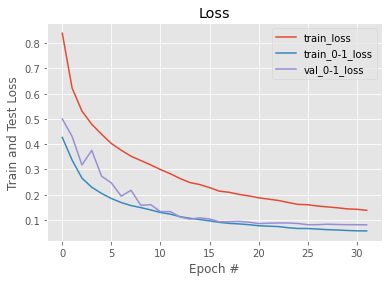

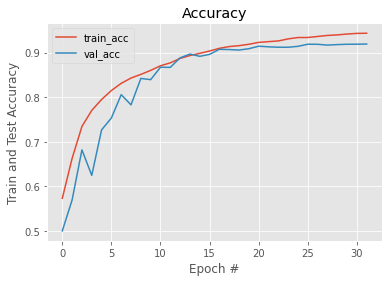

In [ ]:
#costruisco i grafici per la loss e l'accuracy media
mean_loss=np.zeros(n_epochs)
mean_oz_loss=np.zeros(n_epochs)
mean_val_oz_loss=np.zeros(n_epochs)
mean_acc=np.zeros(n_epochs)
mean_val_acc=np.zeros(n_epochs)
min=n_epochs
for h_loss in histories:
  mean_loss = np.add(mean_loss,np.resize(h_loss.history["loss"],(n_epochs,)))
  mean_oz_loss = np.add(mean_oz_loss,np.resize(h_loss.history["custom_zero_loss"],(n_epochs,)))
  mean_val_oz_loss = np.add(mean_val_oz_loss,np.resize(h_loss.history["val_custom_zero_loss"],(n_epochs,)))
  mean_acc= np.add(mean_acc,np.resize(h_loss.history["categorical_accuracy"],(n_epochs,)))
  mean_val_acc = np.add(mean_val_acc,np.resize(h_loss.history["val_categorical_accuracy"],(n_epochs,)))
  if(len(h_loss.history["loss"])<min):
    min=len(h_loss.history["loss"])
mean_loss=np.resize(mean_loss/n_splits,(min,))
mean_oz_loss=np.resize(mean_oz_loss/n_splits,(min,))
mean_val_oz_loss=np.resize(mean_val_oz_loss/n_splits,(min,))
mean_acc=np.resize(mean_acc/n_splits,(min,))
mean_val_acc=np.resize(mean_val_acc/n_splits,(min,))

save_mean_loss_plot(mean_loss,mean_oz_loss,mean_val_oz_loss,OUTPUT_MEAN_LOSS_PATH)
save_mean_acc_plot(mean_acc,mean_val_acc,OUTPUT_MEAN_ACC_PATH)

[[2280.   213.6]
 [ 172.6 2319.8]]


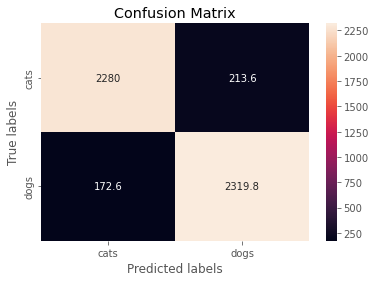

In [ ]:
#costruisco il grafico della matrice di confusione media
ypred_mean=[]
for y_fold in y_mean_conf:
  for y_label in y_fold:
    ypred_mean.append(y_label)
ypred_mean=np.array(ypred_mean)
save_mean_conf_plot(y,ypred_mean,OUTPUT_MEAN_CONF_PATH)

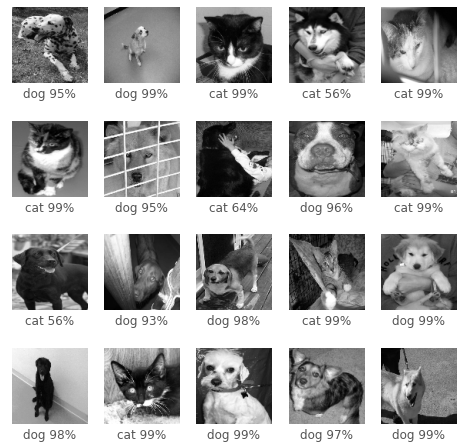

In [ ]:
#[0 1]-> cat,[1 0]->dog
data0=ypred[0]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data0[i][0]*100))+"%" if data0[i][0] > 0.5 else "cat "+str(int(data0[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold0')
plt.show()

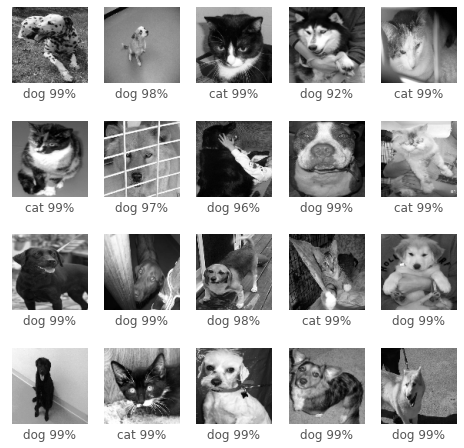

In [ ]:
#[0 1]-> cat,[1 0]->dog
data1=ypred[1]
plt.figure(figsize=(8, 8))
grid_shape = (4, 5)
for i in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(*grid_shape, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i][:,:,0],cmap='gray')
    plt.xlabel(f'{"dog "+str(int(data1[i][0]*100))+"%" if data1[i][0] > 0.5 else "cat "+str(int(data1[i][1]*100))+"%"}', size=12)
plt.savefig('grid_fold1')
plt.show()

In [ ]:
def model_builder():
  model = Sequential()

  model.add (Conv2D (32,(3,3), activation='relu',input_shape = X.shape[1:]))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(64,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(256,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(512,(3,3),activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add (Flatten ())
  model.add (Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add (Dropout (0.4))

  #output layer
  model.add(Dense(2, activation="softmax"))
  
  model.compile (
	loss = "categorical_crossentropy",
	optimizer = "adam",
	metrics = [tf.keras.metrics.CategoricalAccuracy(),custom_zero_loss]
  )

  return model

In [ ]:
model=model_builder()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 49, 49, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 64)      